In [1]:
from fastai.vision.all import *
from pytorch_metric_learning import distances, losses, miners, reducers, testers, regularizers, samplers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
DP = True if torch.cuda.device_count() > 1 else False

In [2]:
# set_seed 42
set_seed(42)

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))
# this notebook runs on RTX 3090 24G
loaders = data.dataloaders(untar_data(URLs.IMAGEWOOF_160), bs=120)

In [3]:
# batch_size must be a multiple of m
# length_before_new_iter >= batch_size must be true
# m * (number of unique labels) >= batch_size must be true
sampler = samplers.MPerClassSampler(loaders.vocab, m=12, batch_size=120, length_before_new_iter=loaders.train.n)
#Fastai 会自动创建一个新的数据加载器，该数据加载器使用相同的数据集，但使用您传递的修改后的关键字参数。
loaders.train = loaders.train.new(shuffle=False, sampler=sampler)

In [4]:
classes = len(loaders.vocab)
classes

10

In [5]:
class CustomModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        embeddings = self.get_embedding(x)
        classifications = self.head(embeddings)
        return nn.Flatten()(embeddings), classifications

    def get_embedding(self, x):
        x = self.encoder(x)
        return x

backbone=efficientnet_v2_s(weights="DEFAULT")
encoder = create_body(backbone)
head = create_head(backbone.classifier[-1].in_features, classes, [1024, 512], 0.5, bn_final=True)
apply_init(head, nn.init.kaiming_normal_)

model=torch.nn.DataParallel(CustomModel(encoder, head)) if DP else CustomModel(encoder, head)
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)] if DP else [params(model.encoder), params(model.head)]

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /home/shenss/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth

100%|██████████| 82.7M/82.7M [00:36<00:00, 2.36MB/s]


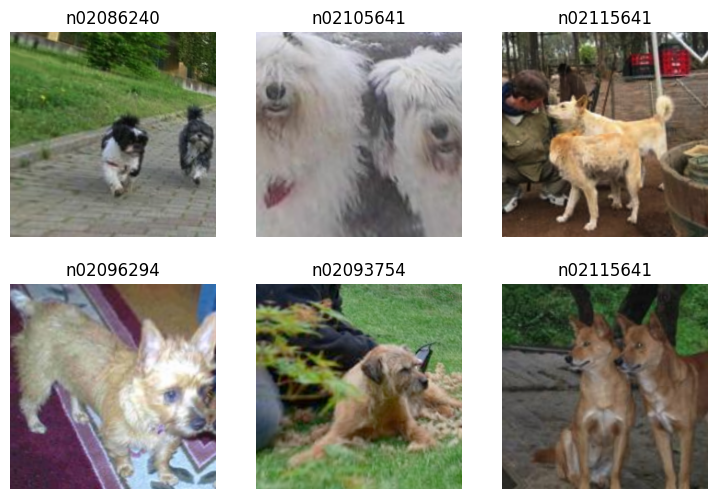

In [6]:
loaders.train.show_batch(max_n=6, nrows=2)

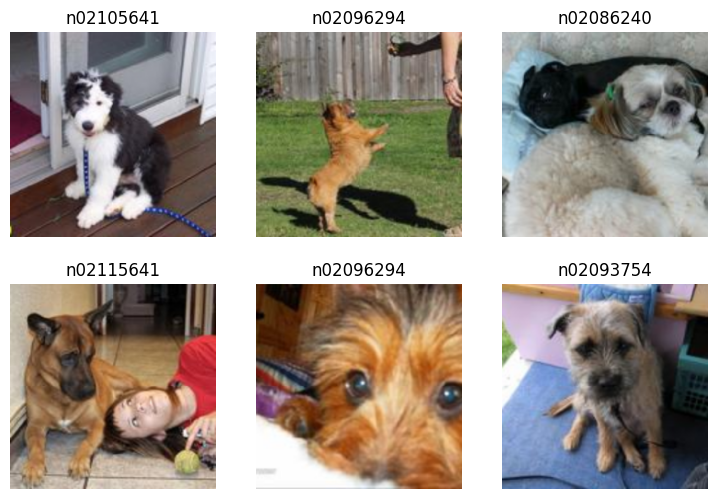

In [7]:
loaders.valid.show_batch(max_n=6, nrows=2)

In [13]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0.1, high=0.9)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")
classification_loss = torch.nn.CrossEntropyLoss()

def mined_loss(miner, loss_func):
    def loss(embeddings, labels):
        mined = miner(embeddings, labels)
        return loss_func(embeddings, labels, mined)
    return loss
  
my_loss = mined_loss(miner = mining_func, loss_func = loss_func)

class CombinedLoss(nn.Module):
    def __init__(self, embed_loss_func, class_loss_func, without_embed=False, without_ce=False):
        super().__init__()
        self.embed_loss_func = embed_loss_func
        self.class_loss_func = class_loss_func
        self.without_embed = without_embed
        self.without_ce = without_ce
    def forward(self, preds, target):
        embeddings, classifications = preds
        embed_loss = self.embed_loss_func(embeddings, target)
        class_loss = self.class_loss_func(classifications, target)
        if self.without_embed:
            return class_loss
        elif self.without_ce:
            return embed_loss
        else:
            return embed_loss + class_loss

combined_loss = CombinedLoss(my_loss, classification_loss)

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def precision(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return precision_score(targ, pred, average='macro',zero_division=1)

def recall(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return recall_score(targ, pred, average='macro',zero_division=1)

def f1score(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return f1_score(targ, pred, average='macro')

learn=Learner(loaders, 
              model,
              loss_func=combined_loss,
              splitter=siamese_splitter,
              cbs=[ShowGraphCallback],
              metrics=[accuracy,precision,recall,f1score])

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,1.288090,0.556768,0.893050,0.887622,0.885372,0.880610,00:30
1,0.972843,0.546775,0.909267,0.901478,0.900237,0.896546,00:30
2,0.822703,0.502668,0.921236,0.914472,0.917932,0.911828,00:29
3,0.707747,0.454805,0.925483,0.919694,0.922464,0.915875,00:27
4,0.602955,0.413813,0.932432,0.925626,0.924610,0.921508,00:29


/home/shenss/miniconda3/envs/py312cu121/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

  return F.conv2d(input, weight, bias, self.stride,


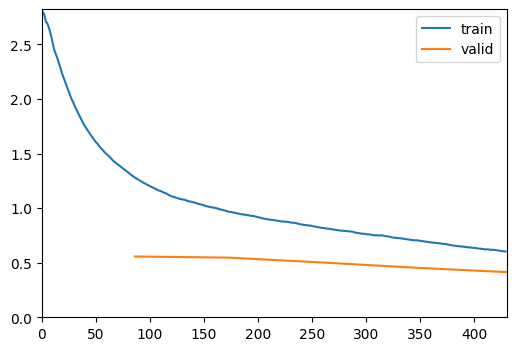

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,0.522336,0.409133,0.944016,0.939327,0.934297,0.933444,00:36
1,0.494385,0.388712,0.948263,0.942433,0.939192,0.938094,00:36
2,0.468169,0.372882,0.949421,0.944511,0.947256,0.941673,00:36
3,0.435538,0.346134,0.957915,0.952564,0.954883,0.951135,00:37
4,0.399311,0.324195,0.957529,0.953786,0.953263,0.950312,00:39
5,0.368830,0.313623,0.959073,0.954467,0.957168,0.952371,00:37
6,0.341736,0.311091,0.959846,0.955469,0.959001,0.953268,00:36
7,0.322939,0.300732,0.962934,0.956395,0.957603,0.954458,00:36
8,0.302757,0.291854,0.962548,0.956939,0.957986,0.954773,00:36
9,0.286642,0.285953,0.967181,0.961527,0.961730,0.959801,00:36


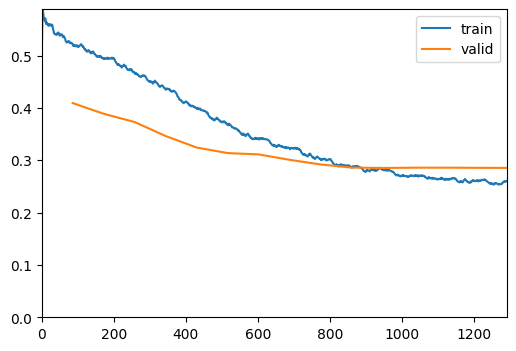

In [15]:
learn.fine_tune(15,freeze_epochs=5)

In [16]:
hooks = Hooks(model.module.encoder if DP else model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0])
    hooks_output = nn.Flatten()(hooks.stored[-1])
    hooks_output = hooks_output.to(ftrs.device)  # move hooks_output to the same device as ftrs
    ftrs = torch.cat((ftrs, hooks_output))

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

OpenBLAS Warning

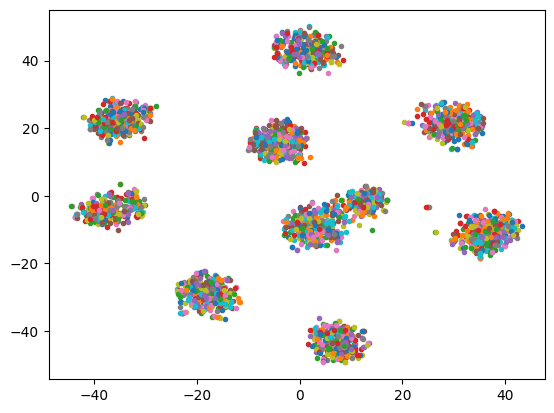

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

In [18]:
from umap import UMAP
umap = UMAP(n_components=2)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

ModuleNotFoundError: No module named 'umap'